## Student Name : Fergus Mc Hale
## Student ID : 18203485
## Model Type :Classification
## Algorithm: Support Vector Machine

## Introduction

This notebook looks at applying a Support Vector Machine to Absenteeism at work.

In [1]:
import sklearn.feature_selection
import pandas as pd
import numpy as np

from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import FactorAnalysis


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score


from statsmodels.nonparametric.kde import KDEUnivariate
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from pprint import pprint

In [2]:
TEST_SIZE = 0.3
CSV_SPLIT = ';'
VERBOSE = False     # Notebook Verbosity
OUTLIER_LIMIT = 25  # Limit to number of outliers allowed in a row of the dataset

In [3]:
NUM_RESULTS = 10

train_mae = np.zeros(NUM_RESULTS)
train_mse = np.zeros(NUM_RESULTS)
train_r2s = np.zeros(NUM_RESULTS)

test_mae = np.zeros(NUM_RESULTS)
test_mse = np.zeros(NUM_RESULTS)
test_r2s = np.zeros(NUM_RESULTS)

## 1. Preparing the dataset

## Loading the dataset

In [4]:
data = pd.read_csv('./data/Absenteeism_at_work.csv',sep=CSV_SPLIT, delimiter=None)

In [5]:
del data['ID']

In [6]:
dataset = data.values

In [7]:
data.isnull().sum().sort_values(ascending=False).head() #check for empty values

Absenteeism time in hours    0
Body mass index              0
Month of absence             0
Day of the week              0
Seasons                      0
dtype: int64

In [8]:
# From DePy_Talk Notebook[1]
# Uses Tukey Inter Quartile Range (IQR) method for Outlier Detection
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])
    
    return outlier_indices, outlier_values

# Initialize empty array to store the number of outliers detected in each row
num_outliers_per_row = np.zeros(data.shape[0])


# Parse each column and find the indices of the rows with an outlier for that column
for column in data.columns:
    tukey_indices, tukey_values = find_outliers_tukey(data[column])
    #print("Outliers = ",len(tukey_indices), "out of ",len(df[column]), "in",column,"Column")
    # For all the outliers found, using the indices, increase the outlier count for rows wit outliers
    for i in range(len(tukey_indices)):
        num_outliers_per_row[tukey_indices[i]]+=1

The max number of outliers detected in a row is :  4.0
The min number of outliers detected in a row is :  0.0
On average, each row contains  0.6743243243243243 columns with data considered as an outlier


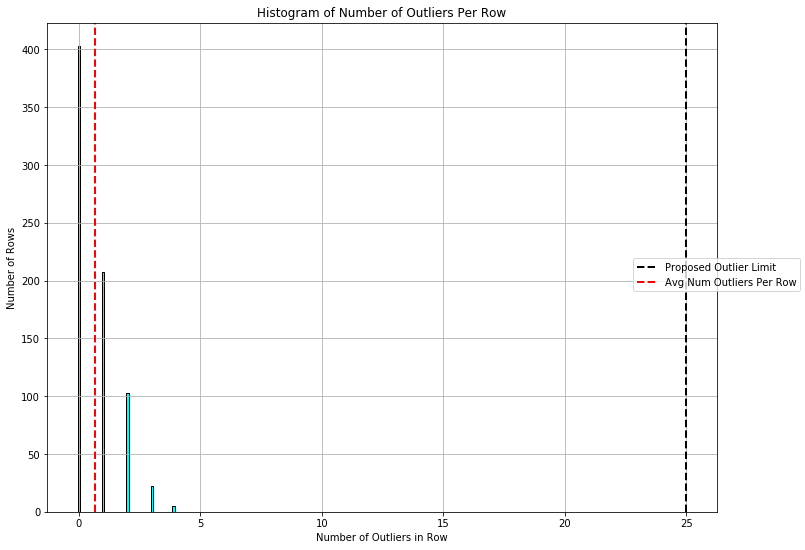

In [9]:
# Parse Array Detailing Number of Outliers per Row
    
print("The max number of outliers detected in a row is : ",num_outliers_per_row.max())
print("The min number of outliers detected in a row is : ",num_outliers_per_row.min())
print("On average, each row contains ",num_outliers_per_row.mean(), "columns with data considered as an outlier")

# Adjust Size of Figures
plt.rcParams["figure.figsize"] = (12,9)

# Display spread of outliers as a histogram
plt.hist(num_outliers_per_row, bins=40, density=False, facecolor='cyan', edgecolor='black', align='left')
plt.xlabel('Number of Outliers in Row')
plt.ylabel('Number of Rows')
plt.title('Histogram of Number of Outliers Per Row')
plt.axvline(OUTLIER_LIMIT, color='k', linestyle='dashed', linewidth=2, label='Proposed Outlier Limit')
plt.axvline(num_outliers_per_row.mean(), color='r', linestyle='dashed', linewidth=2, label='Avg Num Outliers Per Row')
plt.grid(True)
plt.figlegend(loc='right')
plt.show()

In [10]:
dataset = data.values

# Iterate through the per row outlier count and drop any rows that hit the OUTLIER_LIMIT
for i in range(len(num_outliers_per_row)):
    if(num_outliers_per_row[i]>=OUTLIER_LIMIT):
        # Drop row containing the outlier
        data = data.drop([i], axis=0)
        if(VERBOSE==True):
            print("Dropping Row[",i,"]")

print("The limit for retaining a row is",OUTLIER_LIMIT, "outliers. Any rows exceeding this are removed")
print("Dataset Shape After Outlier Removal is ", data.shape)

# Store dataset with outliers removed using Tukey IQR method
tukey_dataset = data.values

The limit for retaining a row is 25 outliers. Any rows exceeding this are removed
Dataset Shape After Outlier Removal is  (740, 20)


In [11]:
variable_names = list(data)

## Split Up Dataset

In [12]:
X = dataset[:, 0:19]
y = dataset[:,19]

In [13]:
x_Train, x_Test, y_Train, y_Test = train_test_split(X, y, test_size = TEST_SIZE, random_state = 0)

## Scale the dataset

In [14]:
 # Scale the dataset

# Scale the data with respect to the training data set 
scaler = StandardScaler() 
scaler.fit(x_Train) 

X_scaled_train = scaler.transform(x_Train) 
# Scaling the test set using the transform defined by the train set. 
X_scaled_test = scaler.transform(x_Test) 

## Support Vector Machine - Linear

## Training

In [15]:
classifer_train = svm.SVC(kernel='linear')

In [16]:
classifer_train.fit(X_scaled_train, y_Train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [17]:
x_Train.shape

(518, 19)

In [18]:
y_Train.shape

(518,)

In [19]:
def plot_support_vectors(support_vectors):
    rows,cols = support_vectors.T.shape

    #Get absolute maxes for axis ranges to center origin
    #This is optional
    maxes = 1.1*np.amax(abs(support_vectors), axis = 0)

    for i,l in enumerate(range(0,cols)):
        xs = [0,support_vectors[i,0]]
        ys = [0,support_vectors[i,1]]
        plt.plot(xs,ys)

    plt.plot(0,0,'ok') #<-- plot a black point at the origin
    plt.axis('equal')  #<-- set the axes to the same scale
    plt.xlim([-maxes[0],maxes[0]]) #<-- set the x axis limits
    plt.ylim([-maxes[1],maxes[1]]) #<-- set the y axis limits
    plt.legend(['V'+str(i+1) for i in range(cols)]) #<-- give a legend
    plt.grid(b=True, which='major') #<-- plot grid lines
    plt.show()

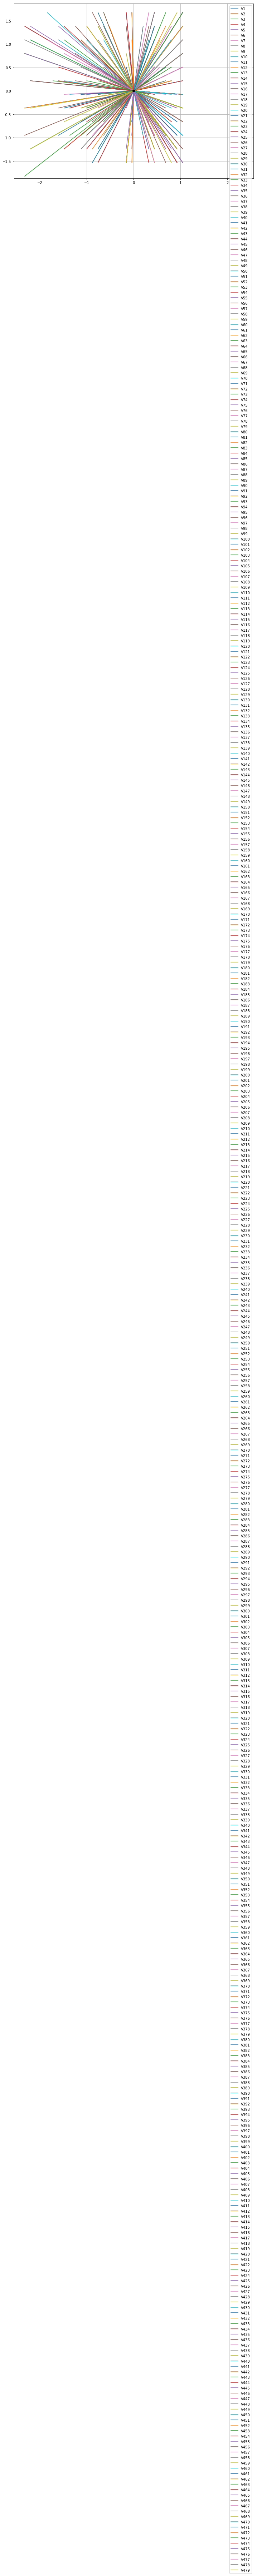

In [47]:
plot_support_vectors(classifer_train.support_vectors_)

In [21]:
classifer_train.support_

array([ 33,  42,  58,  97, 140, 163, 173, 181, 184, 189, 257, 286, 404,
       500, 509,  11,  25,  47,  59,  70,  92,  99, 110, 115, 120, 121,
       128, 133, 135, 136, 139, 153, 156, 174, 177, 179, 188, 199, 204,
       211, 222, 223, 225, 238, 250, 263, 291, 294, 296, 306, 313, 315,
       330, 350, 357, 358, 360, 368, 372, 385, 390, 391, 398, 409, 413,
       423, 428, 454, 458, 473, 480, 483, 493, 502, 506, 514,   2,   4,
        13,  17,  18,  19,  27,  31,  32,  40,  41,  46,  53,  54,  78,
        79,  81,  82, 102, 105, 107, 108, 114, 117, 127, 132, 138, 144,
       146, 147, 149, 155, 157, 167, 169, 176, 178, 196, 197, 201, 207,
       213, 226, 237, 242, 245, 255, 259, 262, 272, 273, 280, 282, 283,
       284, 287, 290, 293, 302, 314, 321, 325, 326, 327, 328, 337, 338,
       340, 351, 354, 359, 363, 366, 374, 378, 379, 384, 388, 406, 407,
       410, 411, 420, 421, 424, 425, 435, 450, 455, 459, 463, 469, 471,
       486, 487, 498, 505, 507, 517,   9,  12,  14,  20,  26,  3

In [22]:
classifer_train.n_support_

array([ 15,  61,  99,  83,  47,   5,   1, 126,  13,  10,   2,   6,   1,
         2,   1,   2,   1,   2,   2])

In [23]:
def print_model_scores(y_hat, y, print_scores=True):
    mae = mean_absolute_error(y, y_hat)
    mse = mean_squared_error(y, y_hat)
    r2s = r2_score(y, y_hat)
    if(print_scores==True):
        print("MAE       :", mae)
        print("MSE       :", mse)
        print("R^2 Score :",r2s)
    
    return mae, mse, r2s

In [24]:
clf_predictions = classifer_train.predict(x_Test)
print("Accuracy: {}%".format(classifer_train.score(x_Test, y_Test) * 100 ))

Accuracy: 0.45045045045045046%


In [25]:
# Determine accuracy using the train set
y_hat_train = classifer_train.predict(X_scaled_train)

print("Model Train Accuracy")
train_mae[0], train_mse[0], train_r2s[0] = print_model_scores(y_hat_train, y_Train)

Model Train Accuracy
MAE       : 3.011583011583012
MSE       : 89.27799227799228
R^2 Score : 0.5251793741367458


## Testing

In [26]:
classifer_test = svm.SVC(kernel='linear')

In [27]:
classifer_test.fit(X_scaled_train, y_Train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

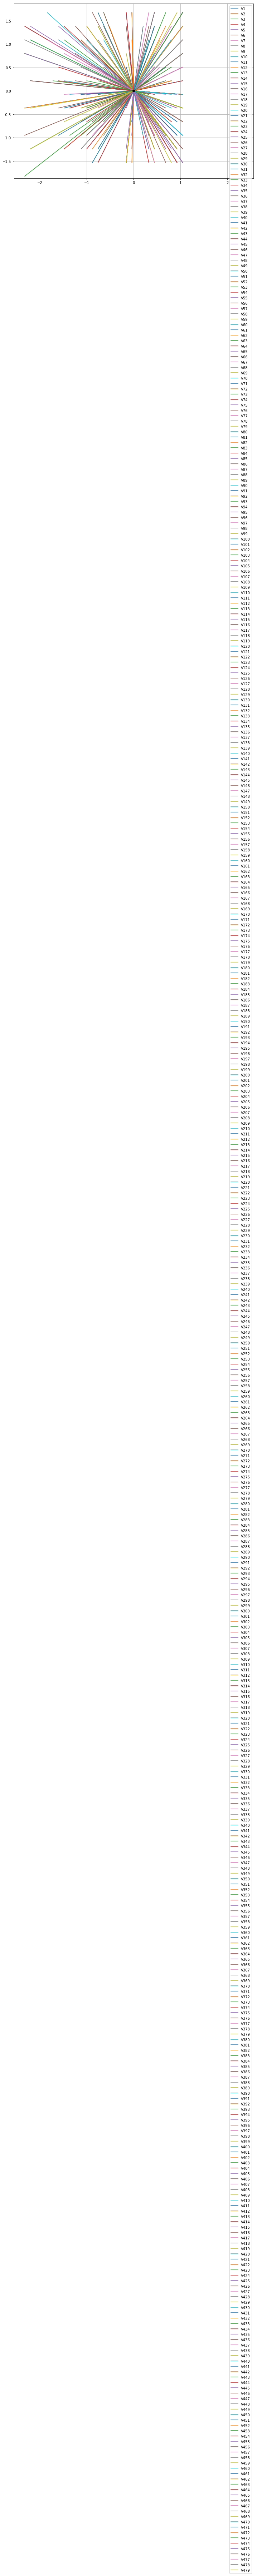

In [28]:
plot_support_vectors(classifer_test.support_vectors_)

In [29]:
classifer_test.support_

array([ 33,  42,  58,  97, 140, 163, 173, 181, 184, 189, 257, 286, 404,
       500, 509,  11,  25,  47,  59,  70,  92,  99, 110, 115, 120, 121,
       128, 133, 135, 136, 139, 153, 156, 174, 177, 179, 188, 199, 204,
       211, 222, 223, 225, 238, 250, 263, 291, 294, 296, 306, 313, 315,
       330, 350, 357, 358, 360, 368, 372, 385, 390, 391, 398, 409, 413,
       423, 428, 454, 458, 473, 480, 483, 493, 502, 506, 514,   2,   4,
        13,  17,  18,  19,  27,  31,  32,  40,  41,  46,  53,  54,  78,
        79,  81,  82, 102, 105, 107, 108, 114, 117, 127, 132, 138, 144,
       146, 147, 149, 155, 157, 167, 169, 176, 178, 196, 197, 201, 207,
       213, 226, 237, 242, 245, 255, 259, 262, 272, 273, 280, 282, 283,
       284, 287, 290, 293, 302, 314, 321, 325, 326, 327, 328, 337, 338,
       340, 351, 354, 359, 363, 366, 374, 378, 379, 384, 388, 406, 407,
       410, 411, 420, 421, 424, 425, 435, 450, 455, 459, 463, 469, 471,
       486, 487, 498, 505, 507, 517,   9,  12,  14,  20,  26,  3

In [30]:
classifer_test.n_support_

array([ 15,  61,  99,  83,  47,   5,   1, 126,  13,  10,   2,   6,   1,
         2,   1,   2,   1,   2,   2])

In [31]:
clf_predictions = classifer_test.predict(X_scaled_test)
print("Accuracy: {}%".format(classifer_test.score(X_scaled_test, y_Test) * 100 ))

Accuracy: 46.3963963963964%


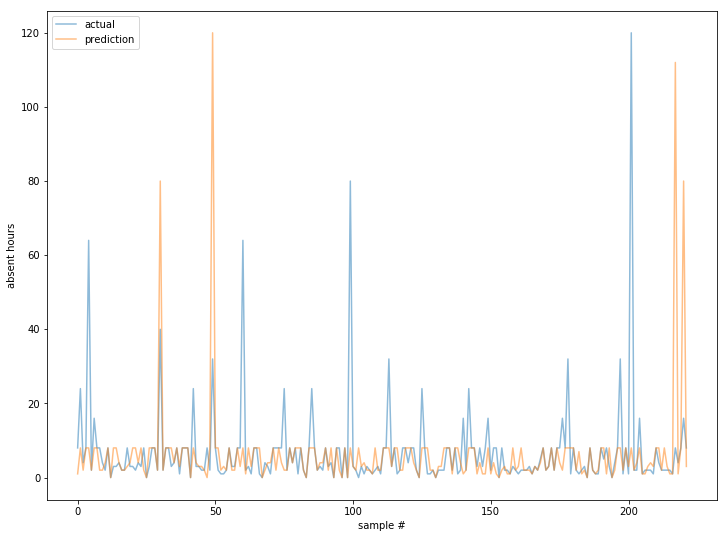

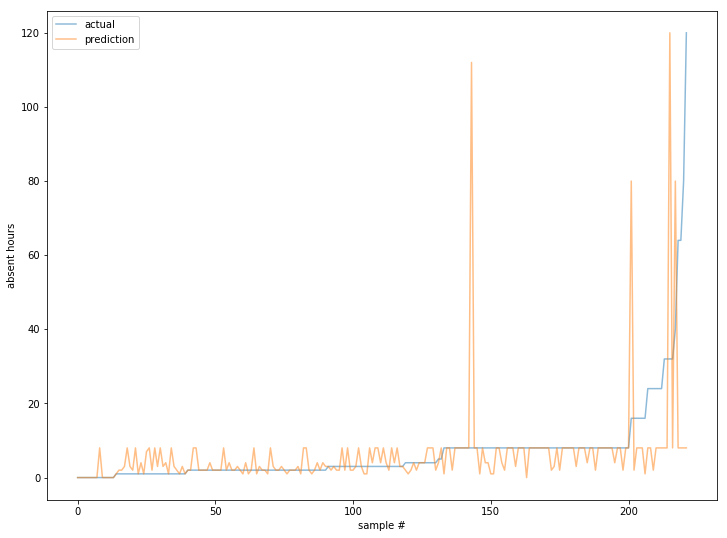

In [32]:
# Provided By Cormac Lavery
predictions = classifer_test.predict(X_scaled_test)
plt.xlabel("sample #")
plt.ylabel("absent hours")
plt.plot(y_Test, alpha=.5, label="actual")
plt.plot(predictions, alpha=.5, label="prediction")
plt.legend(loc='upper left')
plt.show()

sorted_indexs = y_Test.argsort()
plt.xlabel("sample #")
plt.ylabel("absent hours")
plt.plot(y_Test[sorted_indexs], alpha=.5, label="actual")
plt.plot(predictions[sorted_indexs], alpha=.5, label="prediction")
plt.legend(loc='upper left')
plt.show()

## Grid Search CV

In [33]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

In [34]:
def rmsle(y_predicted, y_real):
    return np.sqrt(np.mean(np.power(np.log1p(y_predicted)-np.log1p(y_real), 2)))
def procenterror(y_predicted, y_real):
     return np.round( np.mean(np.abs(y_predicted-y_real) )/ np.mean(y_real) *100 ,1)

## Training

In [35]:
grid_search_train =  GridSearchCV(svm.SVC(),param_grid, refit = True, verbose = 1)

In [36]:
grid_search_train_regr = grid_search_train.fit(X_scaled_test, y_Test)

C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.3s finished
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [37]:
print("Grid Search CV",'%error',procenterror(grid_search_train_regr.predict(X_scaled_train), y_Train),'rmsle',rmsle(grid_search_train_regr.predict(X_scaled_train), y_Train))

Grid Search CV %error 69.9 rmsle 0.8037473946615106


In [38]:
print("Grid Search",'Classification Report')
classif=classification_report(y_Train,np.round(grid_search_train_regr.predict(X_scaled_train)))
print(classif)

# Accuracy
print('--'*40)
logreg_accuracy = round(accuracy_score(y_Train,np.round(grid_search_train_regr.predict(X_scaled_train))) * 100,2)
print('Accuracy', logreg_accuracy,'%')

Grid Search Classification Report
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.97        30
         1.0       0.32      0.11      0.17        62
         2.0       0.36      0.62      0.45       106
         3.0       0.38      0.04      0.07        84
         4.0       0.00      0.00      0.00        48
         5.0       0.00      0.00      0.00         5
         7.0       0.00      0.00      0.00         1
         8.0       0.39      0.76      0.52       140
        16.0       0.00      0.00      0.00        13
        24.0       0.00      0.00      0.00        10
        32.0       0.00      0.00      0.00         2
        40.0       0.00      0.00      0.00         6
        48.0       0.00      0.00      0.00         1
        56.0       0.00      0.00      0.00         2
        64.0       0.00      0.00      0.00         1
        80.0       0.00      0.00      0.00         2
       104.0       0.00      0.00      0.00    

C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
grid_search_test =  GridSearchCV(svm.SVC(),param_grid, refit = True, verbose = 1)

In [40]:
grid_search_test_regr = grid_search_test.fit(X_scaled_test,y_Test)

C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.3s finished
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [41]:
print("Grid Search CV",'%error',procenterror(grid_search_test_regr.predict(X_scaled_test),y_Test),'rmsle',rmsle(grid_search_test_regr.predict(X_scaled_test),y_Test))

Grid Search CV %error 58.6 rmsle 0.7819437447882447


In [42]:
print("Grid Search",'Classification Report')
classif=classification_report(y_Test,np.round(grid_search_test_regr.predict(X_scaled_test)))
print(classif)

# Accuracy
print('--'*40)
logreg_accuracy = round(accuracy_score(y_Test,np.round(grid_search_test_regr.predict(X_scaled_test))) * 100,2)
print('Accuracy', logreg_accuracy,'%')

Grid Search Classification Report
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92        14
         1.0       0.47      0.31      0.37        26
         2.0       0.55      0.80      0.65        51
         3.0       0.25      0.04      0.06        28
         4.0       0.00      0.00      0.00        12
         5.0       0.00      0.00      0.00         2
         8.0       0.54      0.91      0.68        68
        16.0       0.00      0.00      0.00         6
        24.0       0.00      0.00      0.00         6
        32.0       0.00      0.00      0.00         4
        40.0       0.00      0.00      0.00         1
        64.0       0.00      0.00      0.00         2
        80.0       0.00      0.00      0.00         1
       120.0       0.00      0.00      0.00         1

   micro avg       0.56      0.56      0.56       222
   macro avg       0.20      0.21      0.19       222
weighted avg       0.44      0.56      0.47   

C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\fergu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Linear Regression

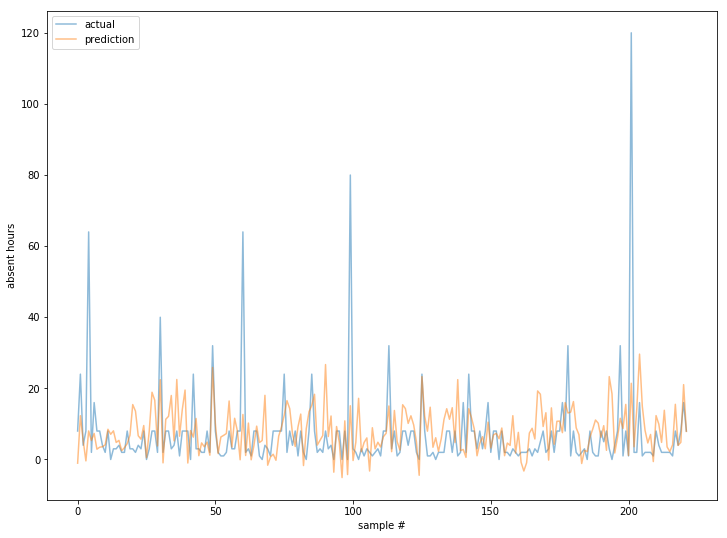

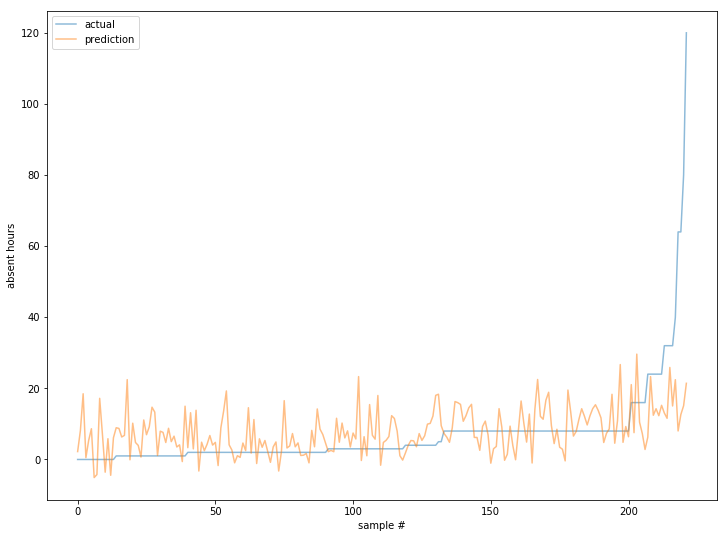

regression model stats
140.2579662796872
0.08241484510066666
classification model stats based on linear accuracy
243.44594594594594
-0.5926538217086412


In [46]:
# Provided By Cormac Lavery
regression = LinearRegression()
regression.fit(x_Train, y_Train)
predictions_regression = regression.predict(x_Test)

plt.xlabel("sample #")
plt.ylabel("absent hours")
plt.plot(y_Test, alpha=.5, label="actual")
plt.plot(predictions_regression, alpha=.5, label="prediction")
plt.legend(loc='upper left')
plt.show()

sorted_indexs = y_Test.argsort()
plt.xlabel("sample #")
plt.ylabel("absent hours")
plt.plot(y_Test[sorted_indexs], alpha=.5, label="actual")
plt.plot(predictions_regression[sorted_indexs], alpha=.5, label="prediction")
plt.legend(loc='upper left')
plt.show()

print("regression model stats")
print(mean_squared_error(y_Test, predictions_regression))
print(r2_score(y_Test, predictions_regression))

print("classification model stats based on linear accuracy")
print(mean_squared_error(y_Test, predictions))
print(r2_score(y_Test, predictions))

#### References
* [1] [SVM Scikit learn] (https://www.learnopencv.com/svm-using-scikit-learn-in-python/)
* [2] [ten-100-correct-models]
(https://www.kaggle.com/plarmuseau/ten-100-correct-models)
* [3] [box-plot-in-python]
(http://www.datasciencemadesimple.com/box-plot-in-python/)
* [4] [Comparing machine learning models in scikit-learn]
(https://www.youtube.com/watch?v=0pP4EwWJgIU)
* [5] [learn-how-to-build-flexible-machine-learning-pipelines-in-sklearn]
(https://fizzylogic.nl/2017/11/07/learn-how-to-build-flexible-machine-learning-pipelines-in-sklearn/)
* [6] [Kevin Goetsch | Deploying Machine Learning using sklearn pipelines]
(https://www.youtube.com/watch?v=URdnFlZnlaE)
* [7]  [A basic soft-margin kernel SVM implementation in Python]
(http://tullo.ch/articles/svm-py/)
* [8] [Remove outliners in pandas dataframe] (https://stackoverflow.com/questions/37718584/removing-outliers-automatically-in-pandas-data-frame)
* [9] [Selected Dataset] (https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work)
* [10] [Factor Analysis] (http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html)
* [11] [Support Vector Machine] (http://scikit-learn.org/stable/modules/svm.html)
* [12] [GridSearchCV] (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)
* [13] [Support Vector Machines a visual explanation] (https://www.youtube.com/watch?v=N1vOgolbjSc)
* [14] [StackOverflow : Training Support Vector Machines] (https://stackoverflow.com/questions/19527014/trouble-training-svm-scikit-learn-package)
* [15] [Plot Support Vectors] (https://stackoverflow.com/questions/42281966/how-to-plot-vectors-in-python-using-matplotlib)
